In [28]:
!nvidia-smi

Tue May 16 13:54:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1D:00.0 Off |                  N/A |
| 31%   42C    P2   111W / 350W |   4027MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1F:00.0 Off |                  N/A |
| 30%   

In [29]:
import torch, torchvision
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from einops import rearrange, repeat
from tqdm.auto import tqdm
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math, os, copy

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [30]:
batch_size = 16
LR_size = 20#low resolution size
img_size = 128
device = torch.device("cuda:0")

# Get data

In [31]:
!pwd

/home/ceryu/Diffs/SimpleSR3/SR3


In [32]:
root_dir = '../data/ffhq_thumbnails'
testroot_dir = '../data/celeba_hq'

In [33]:
transforms_ = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), 
                                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
dataloader = DataLoader(torchvision.datasets.ImageFolder(root_dir, transform=transforms_),
                        batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(torchvision.datasets.ImageFolder(testroot_dir, transform=transforms_), 
                        batch_size=4, shuffle=True, num_workers=8, pin_memory=True)

In [34]:
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


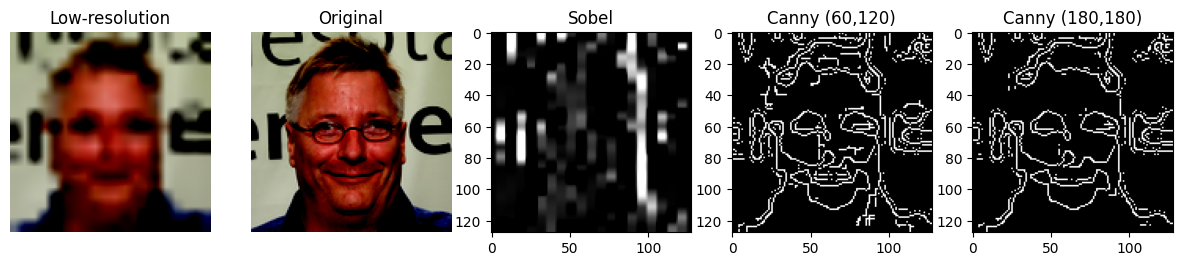

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


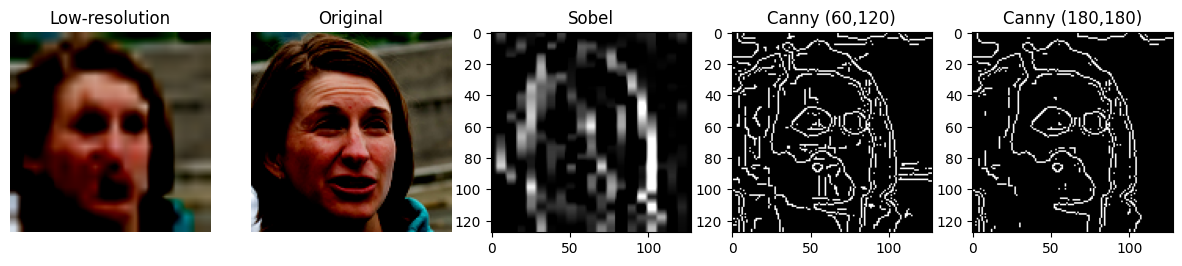

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


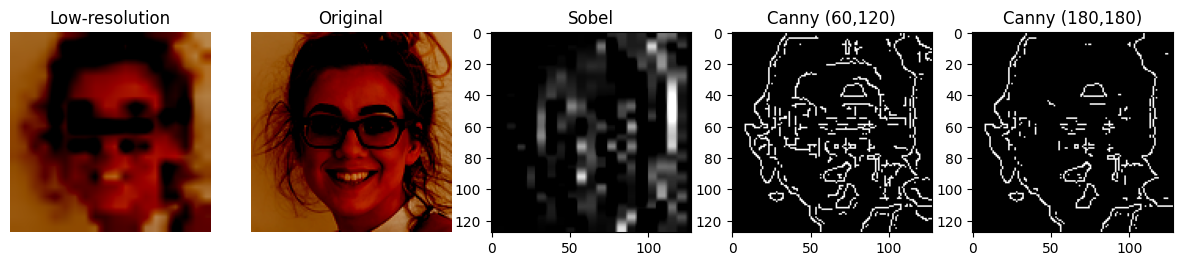

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


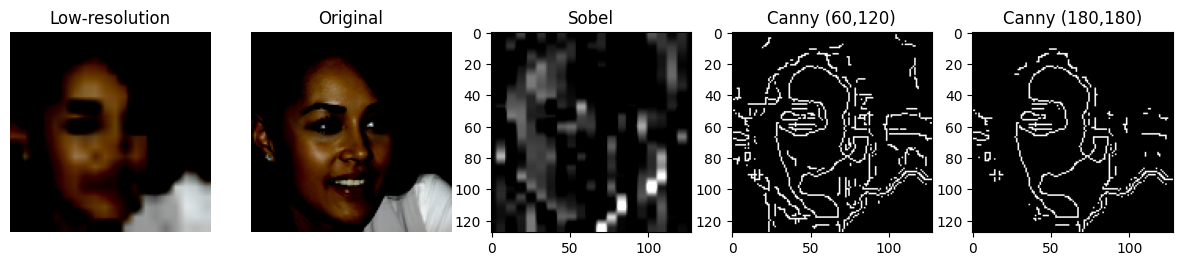

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


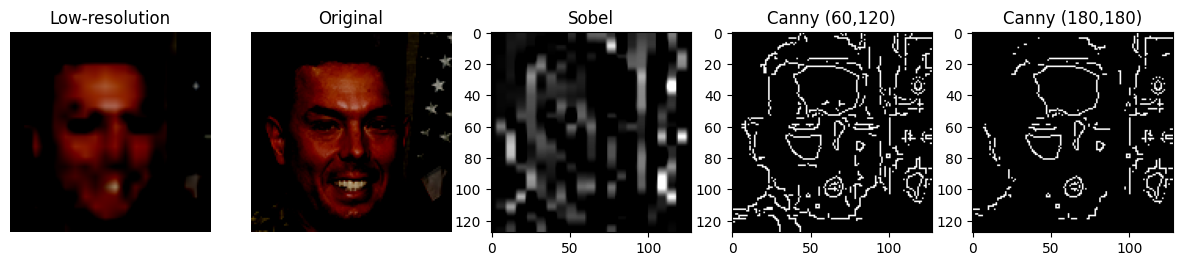

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


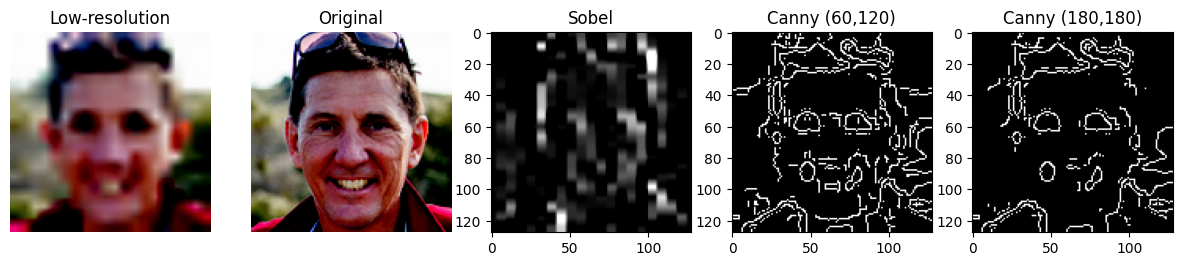

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


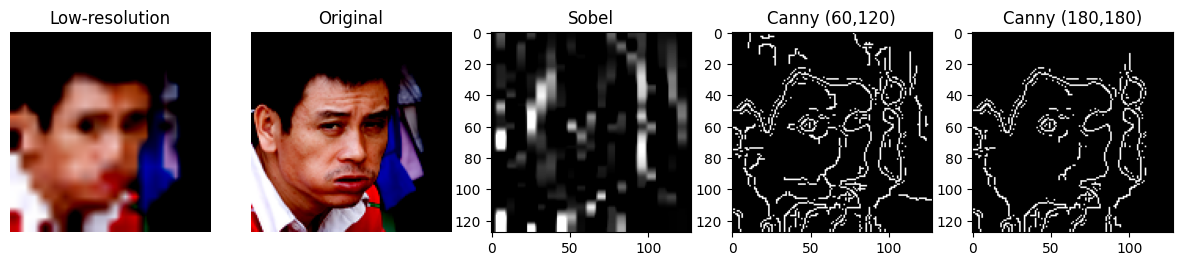

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


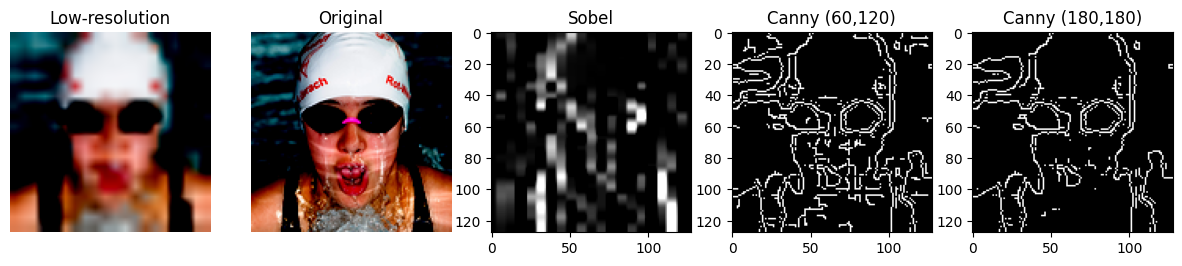

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


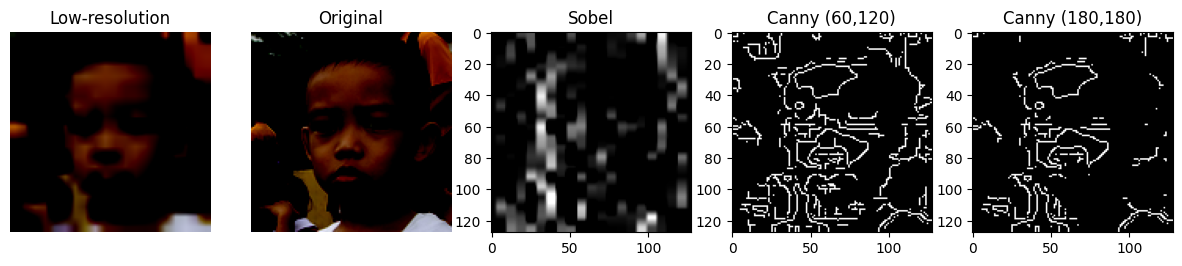

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


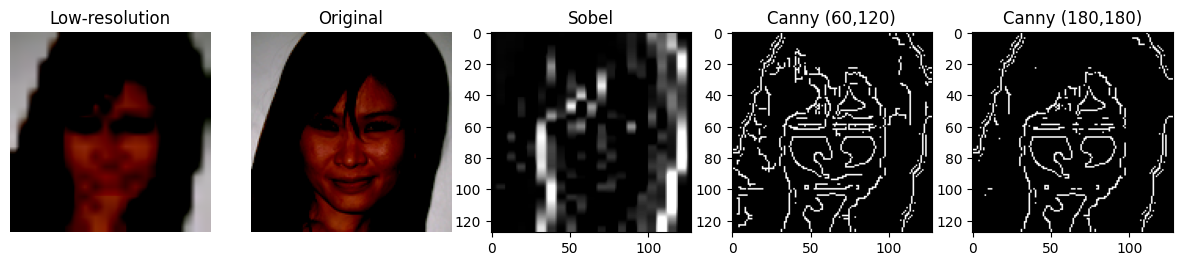

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


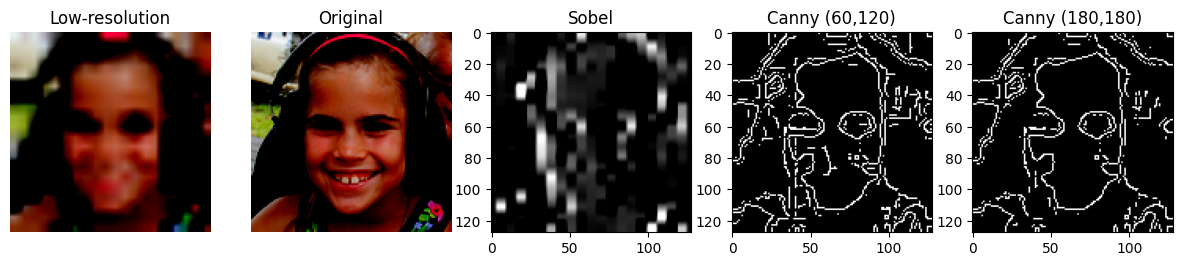

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


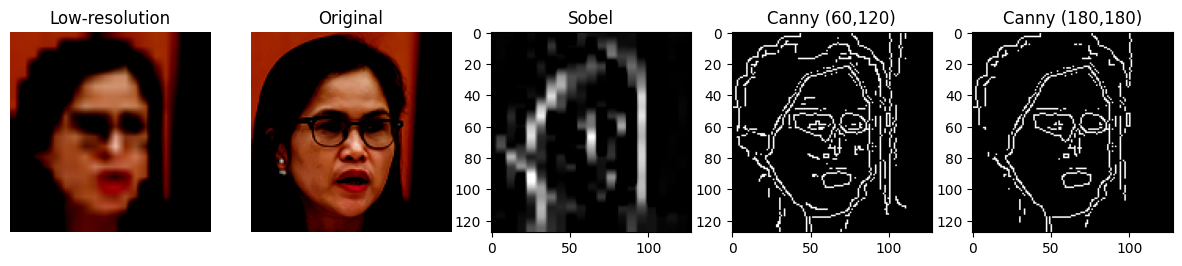

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


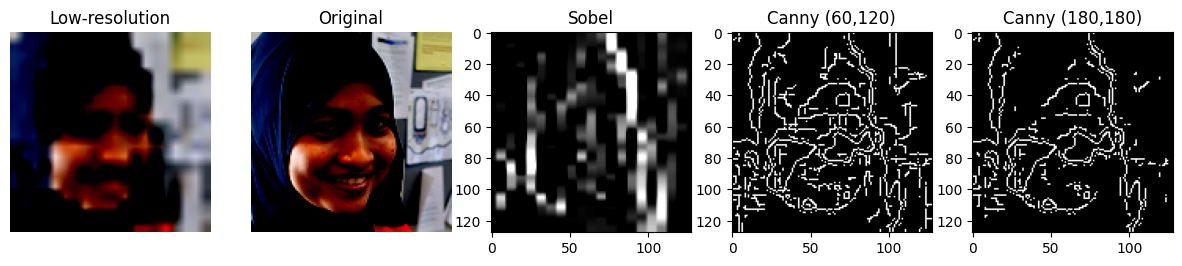

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


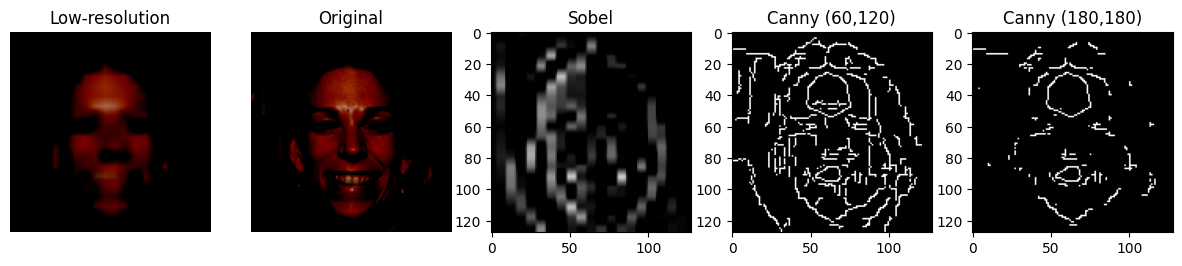

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


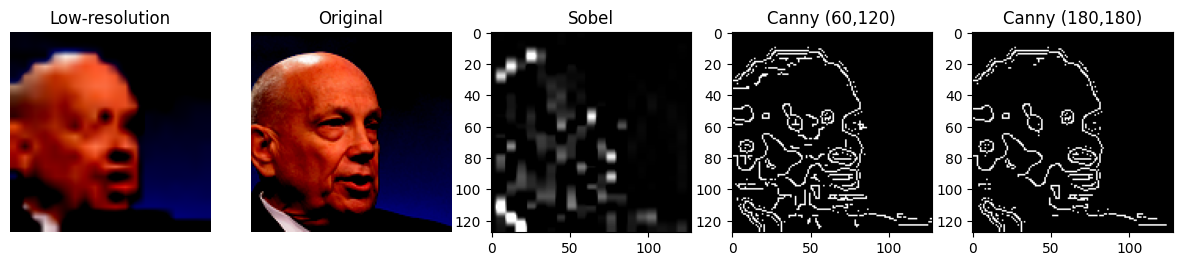

In [42]:
sample_image_batch, _ = next(iter(dataloader))
low_resolution_batch = transforms.Resize(img_size)(transforms.Resize(LR_size)(sample_image_batch))
num_viz = 15
for i in range(num_viz):
    hr_img = sample_image_batch[i].permute(1,2,0).cpu().detach().numpy()
    lr_img = low_resolution_batch[i].permute(1,2,0).cpu().detach().numpy()
    gray = cv2.cvtColor(lr_img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize = (15,10))
    plt.subplot(151)
    plt.axis('off')
    plt.title("Low-resolution")
    plt.imshow(lr_img)
    plt.subplot(152)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(hr_img)
    plt.subplot(153)
    plt.title("Sobel")
    sobel = cv2.Sobel(gray*255, cv2.CV_8U, 1, 0, 3)
    plt.imshow(sobel,cmap='gray', vmin=0, vmax=255)
    plt.subplot(154)
    gray = cv2.cvtColor(lr_img, cv2.COLOR_BGR2GRAY)
    import numpy as np
    slice1Copy = np.uint8(gray*255)
    slicecanny = cv2.Canny(slice1Copy,60,120)
    #edges_high_thresh = cv2.Canny(gray*255, 60, 120)
    plt.title("Canny (60,120)")
    plt.imshow(slicecanny,cmap='gray', vmin=0, vmax=255)
    plt.subplot(155)
    slice1Copy = np.uint8(gray*255)
    eq_th = 180
    slicecanny = cv2.Canny(slice1Copy,eq_th,eq_th)
    #edges_high_thresh = cv2.Canny(gray*255, 60, 120)
    plt.title(f"Canny ({eq_th},{eq_th})")
    plt.imshow(slicecanny,cmap='gray', vmin=0, vmax=255)
    plt.show()